In [4]:
import pickle
from multiprocessing import Pool
import multiprocessing as mp
import numpy as np
import pypianoroll
from tqdm import tqdm
import os
import matplotlib.pyplot as plt
import glob
from collections import defaultdict
from collections import Counter

In [ ]:
def get_dataset_statistics_per_track(num_processes=8):
    """ Calculate how many notes for each instrument land on every resolution step"""
    result_filepath = os.path.join(os.getcwd(), '..', 'plots', 'dataset_statistics_per_track')

    if not os.path.exists(f'{result_filepath}.pkl'):
        # Get all files
        file_paths = glob.glob(os.path.join(script_dir, '..', '/lpd_5/lpd_5_cleansed/*/*/*/*/*.npz'))
        print(f'Found {len(file_paths)} files to process')

        if num_processes is None:
            num_processes = mp.cpu_count()

        print(f'Using {num_processes} processes')

        # Initialize result containers
        resolutions = set()
        total_files = 0
        total_timesteps = 0

        # Track-specific resolution steps counters
        track_resolution_steps = {
            'Drums': {step: 0 for step in range(25)},
            'Piano': {step: 0 for step in range(25)},
            'Guitar': {step: 0 for step in range(25)},
            'Bass': {step: 0 for step in range(25)},
            'Strings': {step: 0 for step in range(25)}
        }

        # Track type occurrence counter
        track_type_counts = {
            'Drums': 0,
            'Piano': 0,
            'Guitar': 0,
            'Bass': 0,
            'Strings': 0
        }

        def process_file(file_path):
            """Process a single file and return its statistics per track"""
            try:
                # Load it as a multitrack object
                m = pypianoroll.load(file_path)

                # Collect resolution
                resolution = m.resolution

                # Get the maximum length across all tracks
                max_length = m.get_max_length()

                # Convert to numpy array for easier processing
                pr = m.stack()  # Shape: (num_tracks, num_timesteps, num_pitches)

                # Identify track types based on program and drum flag
                track_types = []
                for track in m.tracks:
                    if track.is_drum:
                        track_types.append('Drums')
                    elif track.program == 0:
                        track_types.append('Piano')
                    elif track.program == 24:
                        track_types.append('Guitar')
                    elif track.program == 32:
                        track_types.append('Bass')
                    elif track.program == 48:
                        track_types.append('Strings')
                    else:
                        # Handle unexpected programs
                        track_types.append(f'Unknown_Program_{track.program}')

                # Initialize resolution steps counter for each track type
                track_resolution_steps = {
                    'Drums': {step: 0 for step in range(25)},
                    'Piano': {step: 0 for step in range(25)},
                    'Guitar': {step: 0 for step in range(25)},
                    'Bass': {step: 0 for step in range(25)},
                    'Strings': {step: 0 for step in range(25)}
                }

                # Count resolution steps for each track
                for timestep in range(max_length):
                    step_in_resolution = timestep % m.resolution
                    if step_in_resolution < 25:  # Only count steps 0-24
                        # Check each track individually
                        for track_idx, track_type in enumerate(track_types):
                            if track_idx < pr.shape[0]:  # Make sure track exists
                                # Check if this specific track has a note at this timestep
                                has_note = np.any(pr[track_idx, timestep, :] > 0)
                                if has_note and track_type in track_resolution_steps:
                                    track_resolution_steps[track_type][step_in_resolution] += 1

                return {
                    'success': True,
                    'resolution': resolution,
                    'max_length': max_length,
                    'track_types': track_types,
                    'track_resolution_steps': track_resolution_steps
                }

            except Exception as e:
                return {
                    'success': False,
                    'error': str(e),
                    'file_path': file_path
                }

        # Process files using multiprocessing
        with Pool(processes=num_processes) as pool:
            results = list(tqdm(
                pool.imap_unordered(process_file, file_paths, chunksize=50),
                total=len(file_paths),
                desc='Processing files'
            ))

        # Aggregate results
        failed_files = []
        for result in results:
            if result['success']:
                total_files += 1
                resolutions.add(result['resolution'])
                total_timesteps += result['max_length']

                # Count track types in this file
                for track_type in result['track_types']:
                    if track_type in track_type_counts:
                        track_type_counts[track_type] += 1

                # Aggregate track-specific resolution steps
                for track_type, steps_dict in result['track_resolution_steps'].items():
                    if track_type in track_resolution_steps:
                        for step, count in steps_dict.items():
                            track_resolution_steps[track_type][step] += count
            else:
                failed_files.append((result['file_path'], result['error']))

        # Print any failed files
        if failed_files:
            print(f'\n{len(failed_files)} files failed to process:')
            for file_path, error in failed_files[:10]:
                print(f'{file_path}: {error}')

        with open(f'{result_filepath}.pkl', 'wb') as f:
            pickle.dump([resolutions, track_type_counts, track_resolution_steps], f)
    else:
        print(f'Loading results from file.')

        with open(f'{result_filepath}.pkl', 'rb') as f:
            resolutions, track_type_counts, track_resolution_steps = pickle.load(f)

    # Print statistics
    print(f'\nUnique resolutions found: {sorted(resolutions)}')

    print('\nTrack type occurrences:')
    for track_type, count in track_type_counts.items():
        print(f'{track_type}: {count} tracks')

    # Create visualization for each track
    fig, axes = plt.subplots(3, 2, figsize=(20, 15))
    axes = axes.flatten()

    track_types = ['Bass', 'Drums', 'Piano', 'Guitar', 'Strings']

    for idx, track_type in enumerate(track_types):
        ax = axes[idx]
        steps = list(range(25))
        counts = [track_resolution_steps[track_type][step] for step in steps]

        # Only plot if there are notes for this track
        if sum(counts) > 0:
            ax.bar(steps, counts)
            ax.set_title(f'{track_type} - Resolution Steps Distribution')
            ax.set_xlabel('Step within Resolution')
            ax.set_ylabel('Number of Occurrences')
            ax.set_xticks(range(0, 25, 2))
            ax.grid(True, alpha=0.3)
        else:
            ax.text(0.5, 0.5, f'No notes found\nfor {track_type}',
                    ha='center', va='center', transform=ax.transAxes, fontsize=12)
            ax.set_title(f'{track_type} - No Data')

    # Remove the extra subplot
    axes[5].remove()

    plt.tight_layout()
    plt.savefig(f'{result_filepath}.png', dpi=300, bbox_inches='tight')
    plt.show()

In [ ]:
get_dataset_statistics_per_track()

In [1]:
def calculate_discarded_notes_statistics():
    """ Calculate how many drum notes we would """

    ### TODO: Test and let this function plot a small plot
    # Load the pickle file containing dataset statistics
    pickle_path = os.path.join(os.getcwd(), '..', 'plots', 'dataset_statistics_per_track')

    with open(pickle_path, 'rb') as f:
        stats = pickle.load(f)

    # Extract the relevant data
    track_resolution_steps = stats['track_resolution_steps']

    # Define encoding resolutions to test
    encoding_resolutions = [2, 4, 8, 12, 24]

    for encoding_resolution in encoding_resolutions:
        print(f'\nEncoding Resolution: {encoding_resolution}')

        # Calculate step size: 24 // encoding_resolution
        step = 24 // encoding_resolution

        # Note the dataset size in steps
        dataset_size = 0
        covered_dataset_size = 0

        # For each track, calculate what percentage of steps will be covered
        for track_name in ['Drums', 'Piano', 'Guitar', 'Bass', 'Strings']:
            track_steps = track_resolution_steps[track_name]

            # Sum up steps where the index can be cleanly divided by step
            covered_steps = 0
            total_steps = 0

            for step_index in range(25):  # 0 to 24
                count = track_steps[step_index]
                total_steps += count

                # Check if step_index is divisible by step
                if step_index % step == 0:
                    covered_steps += count

            covered_dataset_size += covered_steps
            dataset_size += total_steps

            # Calculate percentage
            if total_steps > 0:
                percentage = (covered_steps / total_steps) * 100
                print(f'{track_name:8}: {percentage:6.2f}% ({covered_steps:,}/{total_steps:,} steps)')
            else:
                print(f'{track_name:8}: No data available')

        percentage = (covered_dataset_size / dataset_size) * 100
        print(f'Complete size: {percentage:6.2f}% ({covered_dataset_size:,}/{dataset_size:,} steps)')
        print('-' * 30)

In [21]:
def load_cleansed_ids(cleansed_ids_file):
    print(f'Loading cleansed IDs from {cleansed_ids_file}...')
    msd_ids = set()

    with open(cleansed_ids_file, 'r', encoding='utf-8') as f:
        for line_num, line in enumerate(f, 1):
            if line_num % 100000 == 0:
                print(f'Processed {line_num:,} lines...')

            line = line.strip()
            if line:
                parts = line.split()
                if len(parts) >= 2:
                    msd_id = parts[1].strip()
                    if msd_id.startswith('TR') and len(msd_id) == 18:
                        msd_ids.add(msd_id)

    print(f'Loaded {len(msd_ids):,} unique MSD IDs')
    return msd_ids


def process_label_provider_folder(folder_path, msd_ids_set):
    """
    Process a label provider folder and count genre occurrences for our songs.
    """
    genre_counts = defaultdict(int)
    id_list_files = glob.glob(os.path.join(folder_path, 'id_list_*.txt'))

    if not id_list_files:
        print(f'No id_list_*.txt files found in {folder_path}')
        return genre_counts

    # Track unique songs that have at least one label
    labeled_songs = set()
    for file_path in id_list_files:
        # Extract genre name from filename
        filename = os.path.basename(file_path)
        genre = filename.replace('id_list_', "").replace('.txt', "")

        # Count how many of our songs are in this genre
        count = 0
        try:
            with open(file_path, 'r', encoding='utf-8') as f:
                for line in f:
                    msd_id = line.strip()
                    if msd_id in msd_ids_set:
                        count += 1
                        # Add to set of labeled songs
                        labeled_songs.add(msd_id)

            if count > 0:
                genre_counts[genre] = count

        except Exception as e:
            print(f'Error processing {file_path}: {e}')

    print(f'\n  Total unique songs with labels: {len(labeled_songs)} out of {len(msd_ids_set)} ({len(labeled_songs) / len(msd_ids_set) * 100:.1f}%)')
    return dict(genre_counts)


def create_pie_chart(genre_counts, provider_name):
    """
    Create a pie chart for genre distribution.
    """
    result_filepath = os.path.join(os.getcwd(), '..', 'plots', f'{provider_name.replace(" ", "_").lower()}_genre_distribution.png')

    # Sort genres by count (descending) for better visualization
    sorted_genres = sorted(genre_counts.items(), key=lambda x: x[1], reverse=True)

    # Limit to top genres if there are too many
    max_genres = 15
    if len(sorted_genres) > max_genres:
        top_genres = sorted_genres[:max_genres]
        other_count = sum(count for _, count in sorted_genres[max_genres:])
        if other_count > 0:
            top_genres.append(('Other', other_count))
        sorted_genres = top_genres

    genres, counts = zip(*sorted_genres)
    total_songs = sum(counts)

    # Create pie chart
    plt.figure(figsize=(12, 8))
    colors = plt.cm.Set3(range(len(genres)))

    wedges, texts, autotexts = plt.pie(
        counts,
        labels=genres,
        autopct='%1.1f%%',
        colors=colors,
        startangle=90
    )

    # Improve text formatting
    for autotext in autotexts:
        autotext.set_color('black')
        autotext.set_fontsize(9)
        autotext.set_weight('bold')

    for text in texts:
        text.set_fontsize(10)

    plt.title(f'Genre Distribution - {provider_name}\n({total_songs:,} total matched labels)', fontsize=14, fontweight='bold', pad=20)

    plt.axis('equal')
    plt.tight_layout()

    # Save the chart
    plt.savefig(result_filepath, dpi=300, bbox_inches='tight')

    # Also show the chart
    plt.show()


def analyze_genre_distributions():
    """
    Main function to analyze genre distributions across label providers.
    """
    cleansed_ids_file = os.path.join(os.getcwd(), '..', 'lpd_5', 'cleansed_ids.txt')
    labels_folder = os.path.join(os.getcwd(), '..', 'lpd_5', 'labels')
    label_provider_folders = {
        'Last.fm Dataset': os.path.join(labels_folder, 'lastfm'),
        'Million Song Dataset Benchmarks': os.path.join(labels_folder, 'amg'),
        'Tagtraum Genre Annotations': os.path.join(labels_folder, 'tagtraum')
    }

    # Load our song IDs for fast lookup
    msd_ids_set = load_cleansed_ids(cleansed_ids_file)

    if not msd_ids_set:
        print('No valid MSD IDs found in cleansed_ids.txt')
        return

    # Process each label provider
    for provider_name, folder_path in label_provider_folders.items():
        # Count genres for this provider
        genre_counts = process_label_provider_folder(folder_path, msd_ids_set)
        # Create pie chart
        create_pie_chart(genre_counts, provider_name)

Loading cleansed IDs from C:\Users\mbrun\Documents\University_Branche\Project\webserver\backend\ml_model\experiments\..\lpd_5\cleansed_ids.txt...
Loaded 21,425 unique MSD IDs

  Total unique songs with labels: 10674 out of 21425 (49.8%)


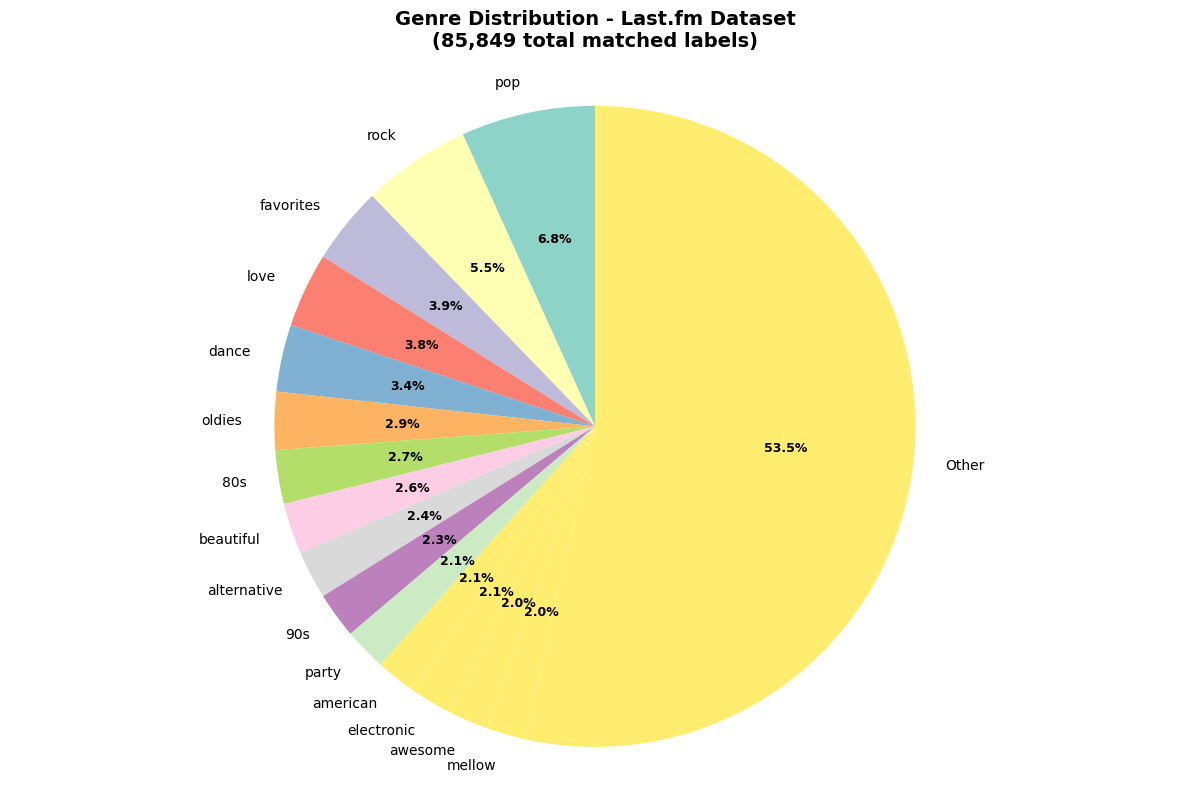


  Total unique songs with labels: 7323 out of 21425 (34.2%)


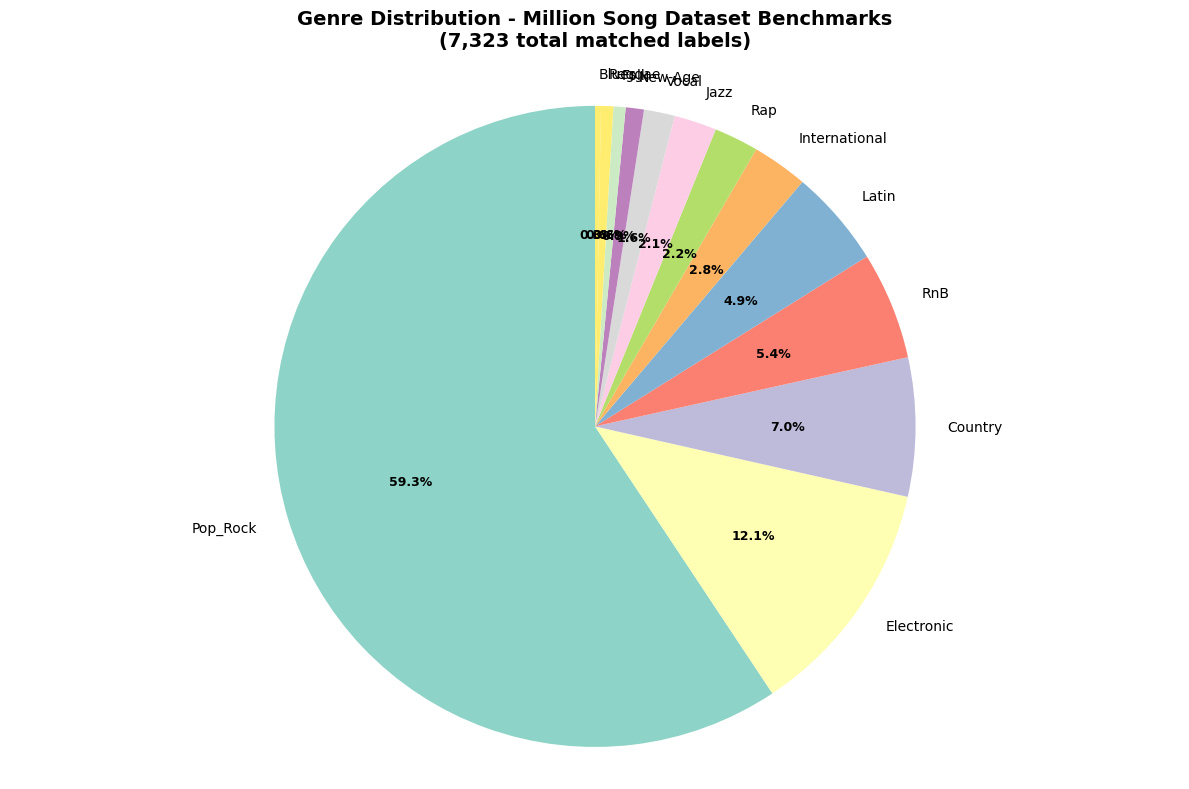


  Total unique songs with labels: 4372 out of 21425 (20.4%)


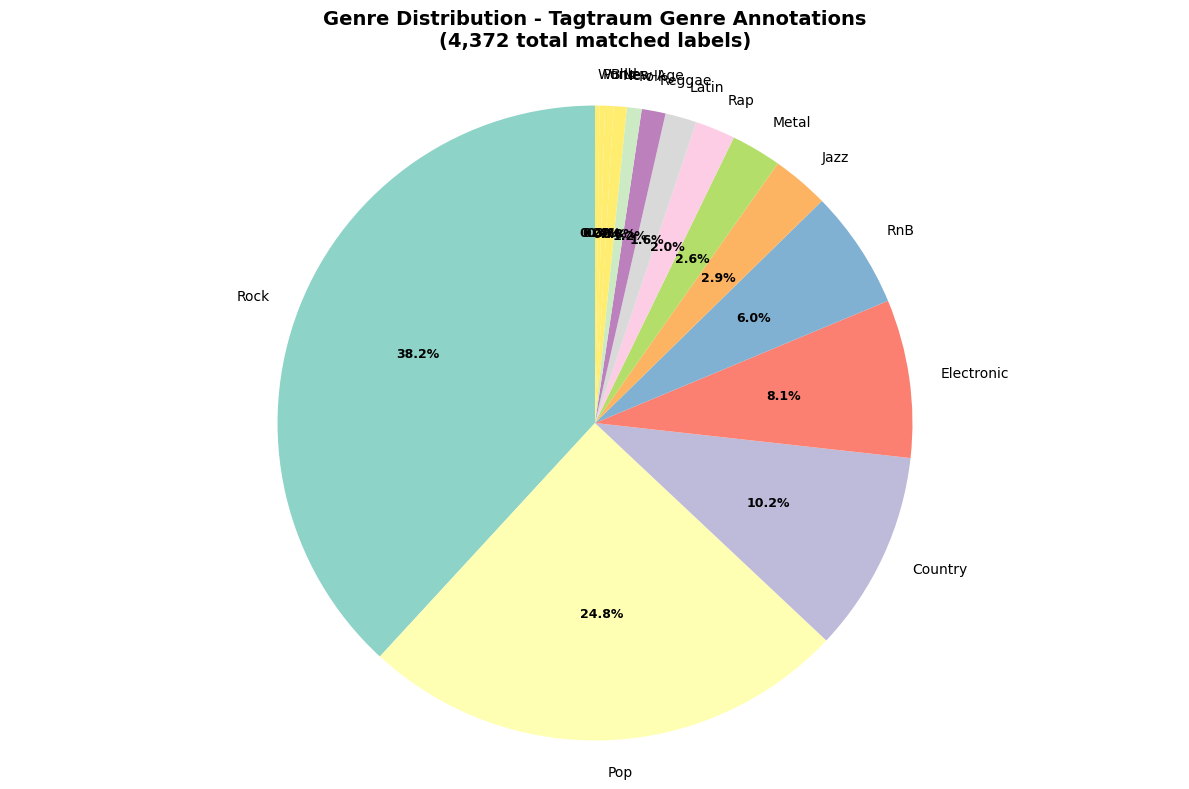

In [22]:
analyze_genre_distributions()

In [14]:
def analyze_and_plot_drum_pitches():
    """
    Analyzes drum pitch occurrences in the LPD-5 dataset and generates a
    plot showing the distribution and coverage.
    """
    file_paths = glob.glob(os.path.join(os.getcwd(), '..', 'lpd_5/lpd_5_cleansed/*/*/*/*/*.npz'))
    result_filepath = os.path.join(os.getcwd(), '..', 'plots', 'drum_pitches')

    if not os.path.exists(f'{result_filepath}.pkl'):
        drum_pitch_counts = Counter()

        print(f'Processing {len(file_paths)} files...')
        for file_path in tqdm(file_paths, desc='Analyzing files'):
            try:
                m = pypianoroll.load(file_path)

                drum_tracks = [t for t in m.tracks if t.is_drum]
                if not drum_tracks:
                    continue

                for drum_track in drum_tracks:
                    # Sum occurrences for each pitch across the time axis
                    pitch_occurrences = np.sum(drum_track.pianoroll > 0, axis=0)

                    for pitch, count in enumerate(pitch_occurrences):
                        if count > 0:
                            drum_pitch_counts[pitch] += int(count)

            except Exception as e:
                print(f'Warning: Error processing {file_path}: {e}')

        with open(f'{result_filepath}.pkl', 'wb') as f:
            pickle.dump(drum_pitch_counts, f)
    else:
        print('Load data from file')
        with open(f'{result_filepath}.pkl', 'rb') as f:
            drum_pitch_counts = pickle.load(f)

    # --- Data Preparation for Plotting ---
    total_notes = sum(drum_pitch_counts.values())
    sorted_pitches_data = sorted(drum_pitch_counts.items(), key=lambda item: item[1], reverse=True)

    # Unzip into separate lists for plotting
    pitches, counts = zip(*sorted_pitches_data)

    # Calculate cumulative coverage as a percentage
    cumulative_counts = np.cumsum(counts)
    cumulative_coverage = cumulative_counts / total_notes * 100

    # --- Plotting ---
    print('\nGenerating plot...')
    fig, ax1 = plt.subplots(figsize=(20, 10))

    # Bar plot for pitch counts (primary y-axis on the left)
    x_indices = np.arange(len(pitches))
    ax1.bar(x_indices, counts, color='cornflowerblue', label='Occurrences per Pitch')
    ax1.set_xlabel('Drum Pitch (MIDI Note Number)', fontsize=14)
    ax1.set_ylabel('Number of Occurrences', color='cornflowerblue', fontsize=14)
    ax1.tick_params(axis='y', labelcolor='cornflowerblue')
    # Set the x-axis to show the actual MIDI pitch numbers
    ax1.set_xticks(x_indices)
    ax1.set_xticklabels(pitches, rotation=90, fontsize=9)
    ax1.set_yscale('log') # Use a log scale for better visibility of less common pitches

    # Line plot for cumulative coverage (secondary y-axis on the right)
    ax2 = ax1.twinx()
    ax2.plot(x_indices, cumulative_coverage, color='crimson', marker='.', markersize=4, linestyle='-', label='Cumulative Coverage')
    ax2.set_ylabel('Cumulative Coverage (%)', color='crimson', fontsize=14)
    ax2.tick_params(axis='y', labelcolor='crimson')
    ax2.set_ylim(0, 105) # Give 5% padding at the top

    # Add vertical lines and text for coverage thresholds
    colors = {90: 'darkgreen', 95: 'darkorange', 99: 'purple'}
    for p in [90, 95, 99]:
        try:
            # Find the first index where coverage exceeds the threshold
            num_pitches_needed = np.where(cumulative_coverage >= p)[0][0]
            label = f'{p}%'
            color = colors[p]

            # Draw the vertical line
            ax1.axvline(x=num_pitches_needed, color=color, linestyle='--',
                        label=f'{label} Coverage ({num_pitches_needed + 1} pitches)')

            # Add a text annotation to the plot
            ax1.text(num_pitches_needed + 0.5, max(counts) * 0.5, f'{num_pitches_needed + 1} pitches',
                     rotation=90, color=color, va='center', fontsize=12, backgroundcolor='white')

        except IndexError:
            print(f"Warning: Could not find index to reach {p}% coverage.")

    # --- Final Touches ---
    fig.suptitle('Drum Pitch Distribution and Coverage in LPD-5 Dataset', fontsize=18, weight='bold')
    # Combine legends from both axes into a single box
    lines, labels = ax1.get_legend_handles_labels()
    lines2, labels2 = ax2.get_legend_handles_labels()
    ax2.legend(lines + lines2, labels + labels2, loc='center right', fontsize=12)

    ax1.grid(True, which='major', axis='y', linestyle='--', alpha=0.6)
    fig.tight_layout(rect=[0, 0, 1, 0.96]) # Adjust layout to make room for the suptitle

    # Save the plot
    print(f'Saving plot to {result_filepath}.png')
    plt.savefig(f'{result_filepath}.png', dpi=300, bbox_inches='tight')
    plt.show()

Load data from file

Generating plot...
Saving plot to C:\Users\mbrun\Documents\University_Branche\Project\webserver\backend\ml_model\experiments\..\plots\drum_pitches.png


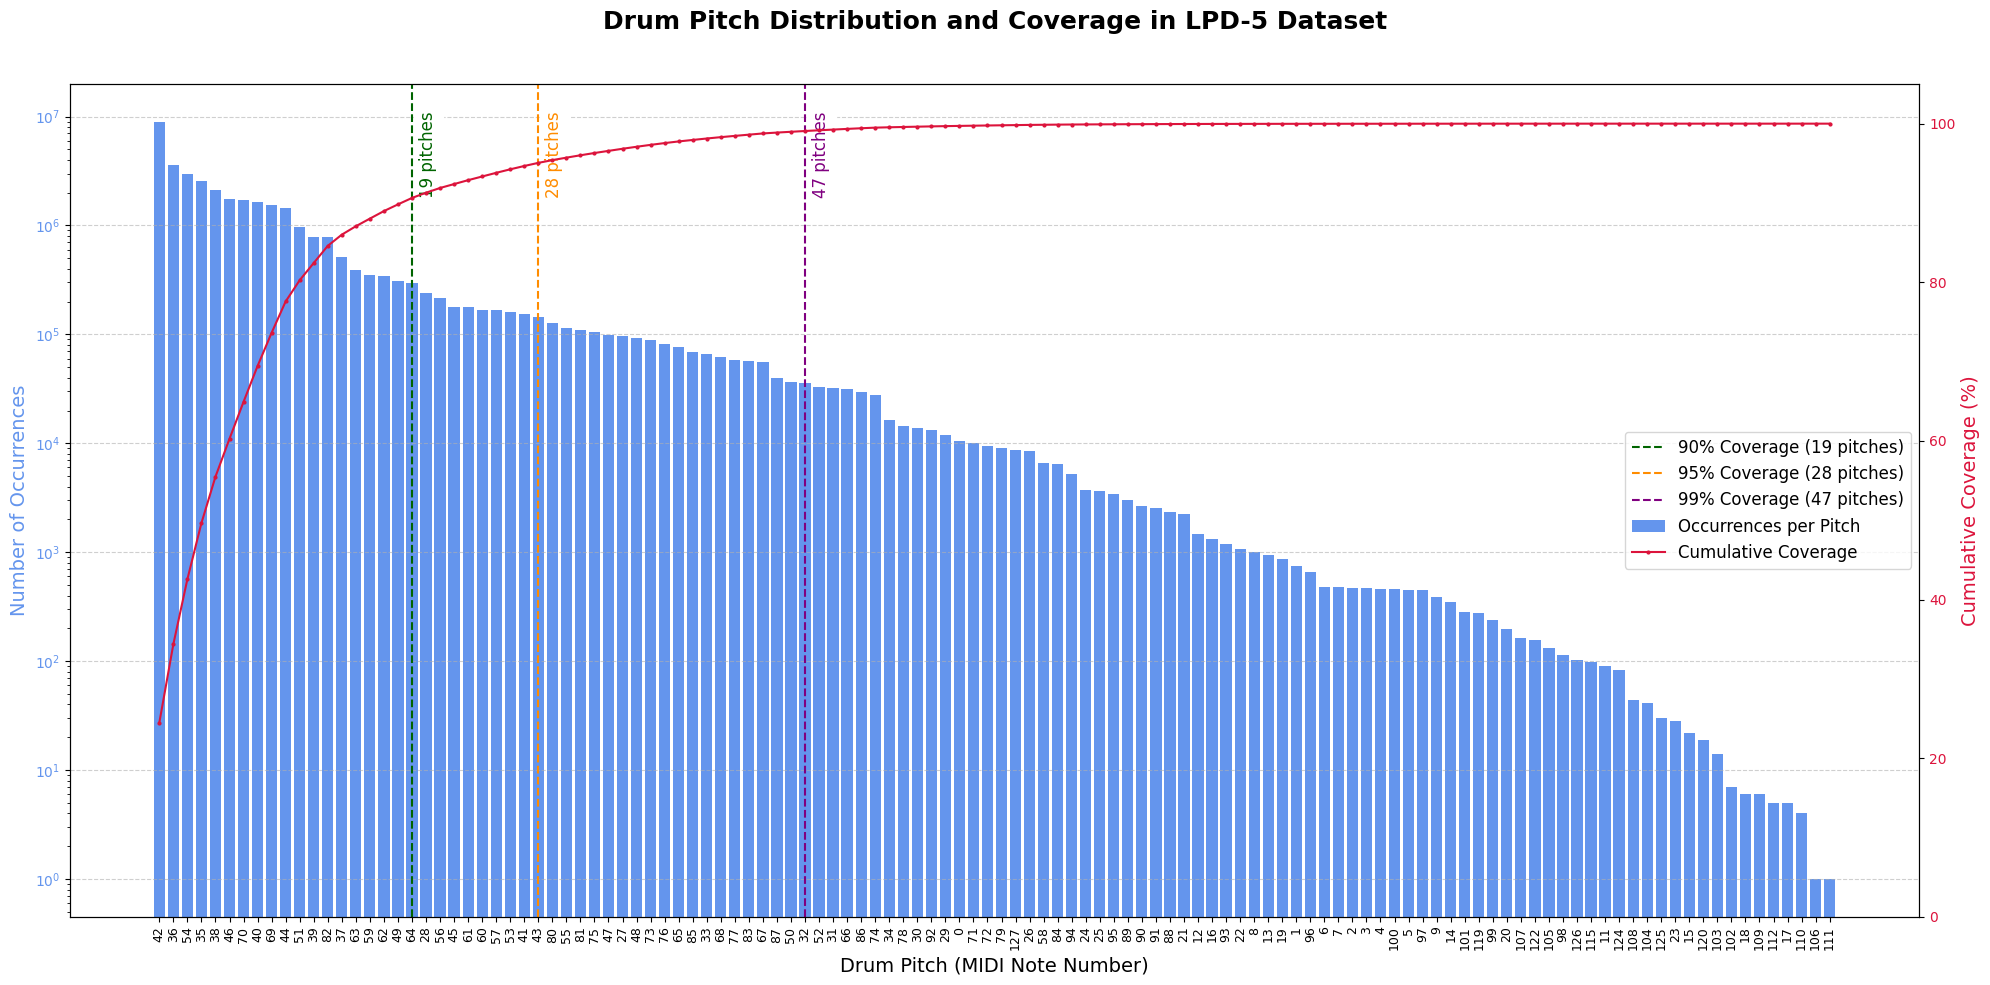

In [15]:
analyze_and_plot_drum_pitches()